# Kaggle dataset link - 'https://www.kaggle.com/datasets/omkargurav/face-mask-dataset'

In [22]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 94% 154M/163M [00:00<00:00, 1.61GB/s]
100% 163M/163M [00:00<00:00, 1.58GB/s]


In [4]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [5]:
!pip install split-folders

# **Import Modules**

In [17]:
import pandas as pd
import numpy as np
import os
import random
import splitfolders
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential

# **Load The Dataset**

In [18]:
BASE_DIR = '/content/face-mask-dataset'

mask_classes = os.listdir(BASE_DIR)

print("Classes:", mask_classes)

Classes: ['without_mask', 'with_mask']


In [3]:
!rm -rf /content/face-mask-dataset/.ipynb_checkpoints


# **Data Preprocessing**

In [19]:
splitfolders.ratio(
    BASE_DIR,
    output='face-mask',
    seed= 42,
    ratio=(0.8, 0.1, 0.1),
    group_prefix=None
)

Copying files: 7553 files [00:01, 4573.93 files/s]


In [20]:
# Parameters

IMG_SIZE = 224
BATCH_SIZE = 32

# Image Data Generators

# train_datagen = ImageDataGenerator(
#     rescale= 1./255,
#     horizontal_flip= True,
#     rotation_range= 15,
#     zoom_range= 0.1
# )

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    shear_range=0.15,
    horizontal_flip=True
)


val_datagen  = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [21]:
# Load Face Mask Data

train_generator = train_datagen.flow_from_directory(
    '/content/face-mask/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = 32,
    shuffle= True,
    class_mode = 'binary',
    classes=mask_classes
)

val_generator = val_datagen.flow_from_directory(
    '/content/face-mask/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = 32,
    shuffle= False,
    class_mode = 'binary',
    classes=mask_classes
)

test_generator = test_datagen.flow_from_directory(
    '/content/face-mask/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = 32,
    shuffle= False,
    class_mode = 'binary',
    classes=mask_classes
)

Found 6042 images belonging to 2 classes.
Found 754 images belonging to 2 classes.
Found 757 images belonging to 2 classes.


In [22]:
# Class Names (From Data Generator)

class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['without_mask', 'with_mask']


| class_mode    | labels look like | How to get class   |
| ------------- | ---------------- | ------------------ |
| `binary`      | `0` / `1`        | `int(label)`       |
| `sparse`      | `0,1,2,...`      | `int(label)`       |
| `categorical` | `[0,1,0...]`     | `np.argmax(label)` |


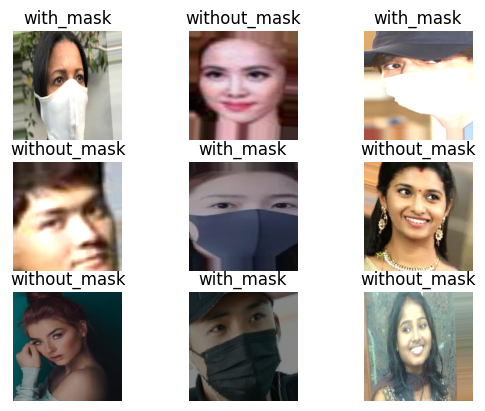

In [23]:
# Visualize Sample Images

for images, labels in train_generator:
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])

    true_index = int(labels[i]) # sparse / binary
    true_label = class_names[true_index]
    plt.title(true_label)
    plt.axis('off')

  break

plt.show()



In [15]:
# # Visualize Sample Images (categorical labels) when class_mode = category

# plt.figure(figsize=(9, 9))

# for images, labels in train_generator:
#     for i in range(9):
#         plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i])

#         class_index = np.argmax(labels[i])   # 🔑 change here
#         plt.title(class_names[class_index])

#         plt.axis("off")
#     break

# plt.show()


| Mode        | labels[i] looks like | Use                    |
| ----------- | -------------------- | ---------------------- |
| binary      | `1`                  | `int(labels[i])`       |
| sparse      | `2`                  | `int(labels[i])`       |
| categorical | `[0,1,0]`            | `np.argmax(labels[i])` |


# **Model Building**

In [24]:
from tensorflow.keras.applications import VGG16

In [25]:
# VGG16 Transfer Learning Model

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Freeze base

base_model.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
train_generator.num_classes

2

In [14]:
# Dense Layers

# model = Sequential([
#     Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
#     base_model,
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

In [28]:
# Functional API approach -. best approach

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

# Output layer
outputs = Dense(1, activation="sigmoid")(x)

# Build model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Another Functional API approach

# IMG_SIZE = 224

# inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# base_model = VGG16(
#     weights="imagenet",
#     include_top=False
# )
# base_model.trainable = False

# x = base_model(inputs)
# x = Flatten()(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
# outputs = Dense(1, activation="sigmoid")(x)

# model = Model(inputs, outputs)

# model.compile(
#     optimizer="adam",
#     loss="binary_crossentropy",
#     metrics=["accuracy"]
# )

# model.summary()

In [ ]:
# Compile the model

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# If manual CNN model is to be used

# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D(2, 2),

#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),

#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),

#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=10
# )

In [29]:
# Train the model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 13/189 ━━━━━━━━━━━━━━━━━━━━ 1:19 450ms/step - accuracy: 0.5046 - loss: 3.0360

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 106s 543ms/step - accuracy: 0.7721 - loss: 0.8505 - val_accuracy: 0.9562 - val_loss: 0.1064
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 98s 517ms/step - accuracy: 0.9160 - loss: 0.1934 - val_accuracy: 0.9775 - val_loss: 0.0806
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 97s 513ms/step - accuracy: 0.9372 - loss: 0.1703 - val_accuracy: 0.9814 - val_loss: 0.0633
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 100s 528ms/step - accuracy: 0.9331 - loss: 0.1704 - val_accuracy: 0.9788 - val_loss: 0.0613
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 99s 521ms/step - accuracy: 0.9423 - loss: 0.1456 - val_accuracy: 0.9695 - val_loss: 0.0766
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 99s 522ms/step - accuracy: 0.9465 - loss: 0.1396 - val_accuracy: 0.9788 - val_loss: 0.0580
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 98s 518ms/step - accuracy: 0.9469 - loss: 0.1411 - val_accuracy: 0.9788 - val_loss: 0.0594
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 98s 517ms/step - accuracy: 0.9428 - loss: 0.1378 - v

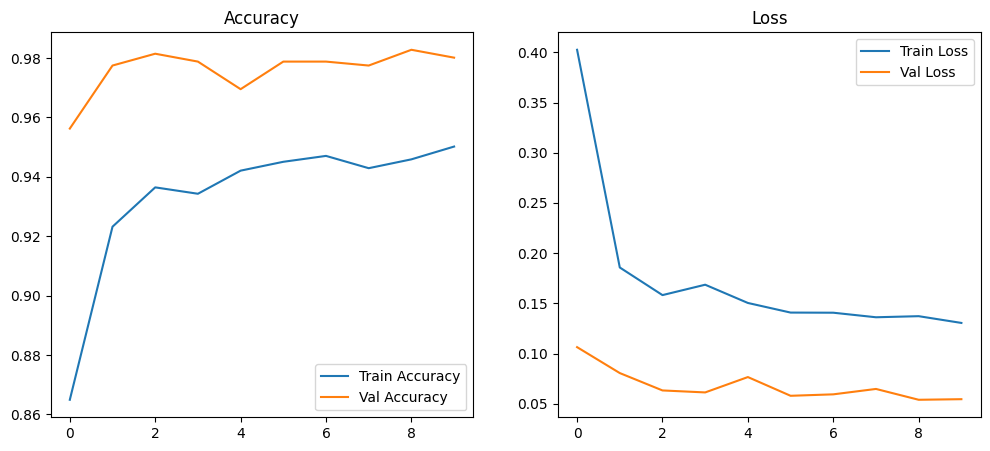

In [30]:
# Plot

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.show()


# **Model Evaluation**

In [31]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {100 * test_accuracy:.2f}%')

24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 653ms/step - accuracy: 0.9597 - loss: 0.0762
Test Accuracy: 97.62%


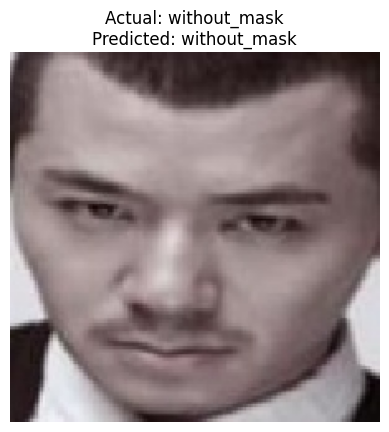

In [32]:
# Predict Random Test Image

for images, labels in test_generator:
    img = images[0]

    # True label
    true_index = int(labels[0])
    true_label = class_names[true_index]

    # Prediction
    predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)

    prob = predictions[0][0]          # ✅ extract scalar value
    pred_index = int(prob > 0.5)      # ✅ threshold
    pred_label = class_names[pred_index]

    plt.imshow(img)
    plt.title(f'Actual: {true_label}\nPredicted: {pred_label}')
    plt.axis('off')
    break


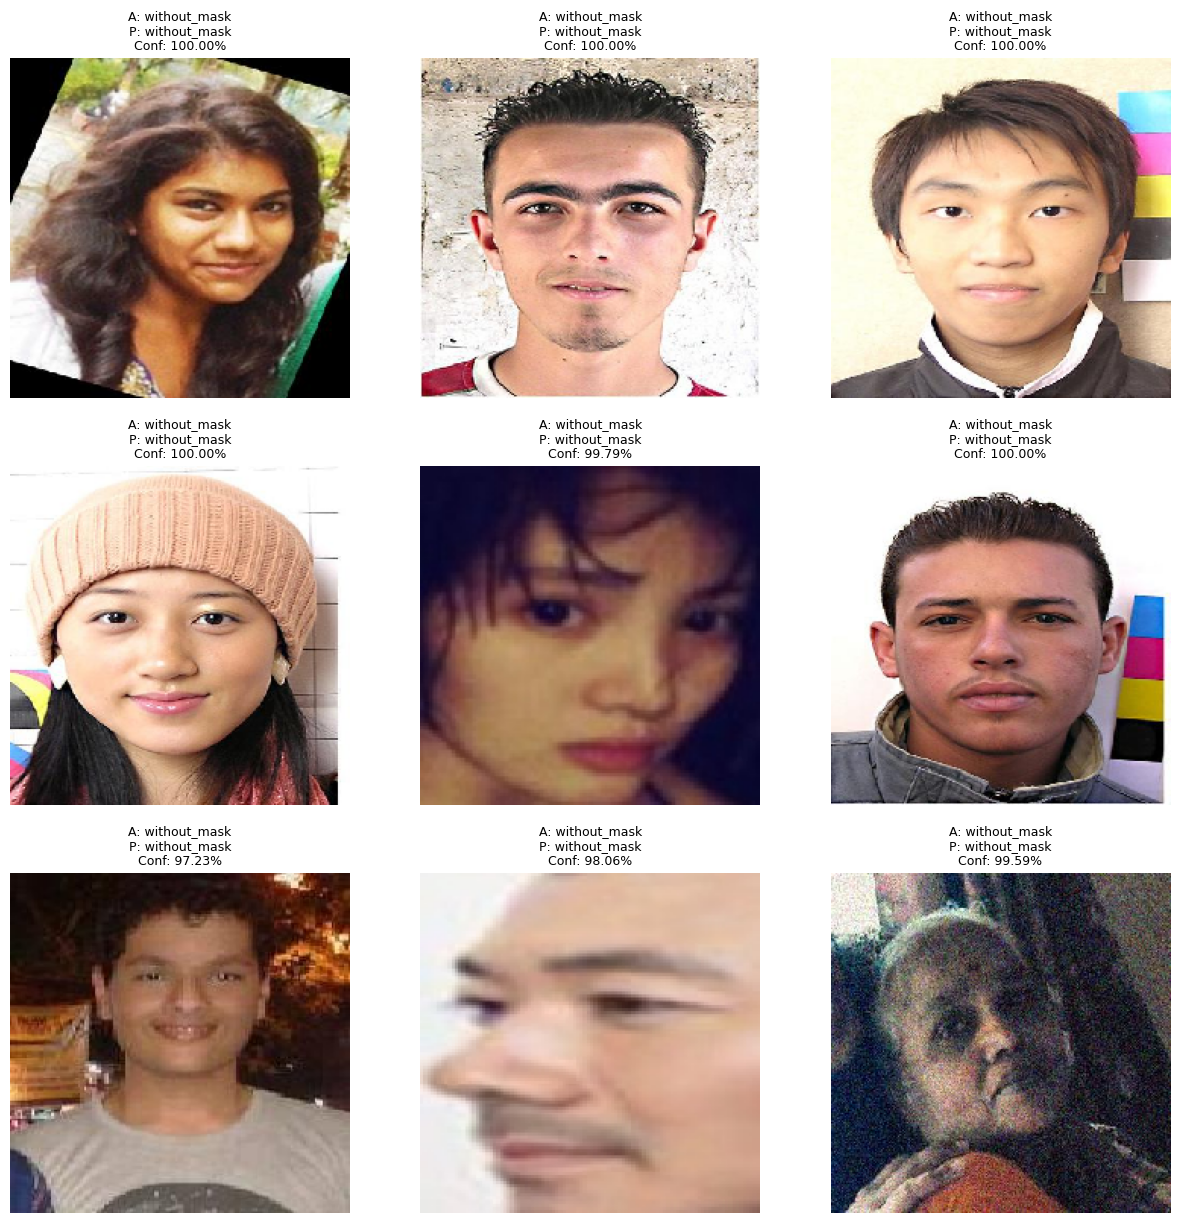

In [33]:
# Multiple Predictions with Confidence

plt.figure(figsize=(15,15))

for images, labels in test_generator:
    for i in range(9):
        img = images[i]

        # True label
        true_index = int(labels[i])
        true_label = class_names[true_index]

        # Prediction
        predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)

        prob = predictions[0][0]          # P(class = 1)
        pred_index = int(prob > 0.5)      # threshold
        pred_label = class_names[pred_index]

        # ✅ Confidence of the predicted class
        if pred_index == 1:
            confidence = prob * 100
        else:
            confidence = (1 - prob) * 100

        # Plot
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(
            f"A: {true_label}\n"
            f"P: {pred_label}\n"
            f"Conf: {confidence:.2f}%",
            fontsize=9
        )
        plt.axis("off")
    break

plt.show()


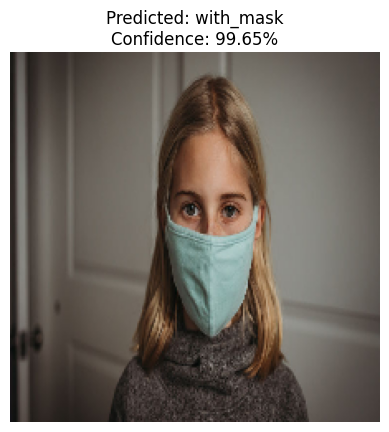

In [36]:
# Test with External Image

from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/mask.jpg"   # change if needed

# Load & preprocess
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array, verbose=0)

prob = prediction[0][0]          # single probability
pred_index = int(prob > 0.5)     # threshold
predicted_label = class_names[pred_index]

# ✅ Confidence of the predicted class
if pred_index == 1:
    confidence = prob * 100
else:
    confidence = (1 - prob) * 100

# Show result
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
plt.show()


In [35]:
model.save("face_mask_vgg16_model-2.h5")
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [ ]:
# model.save("/kaggle/working/face_mask_vgg16_model-2.h5")
# print("✅ Model saved successfully!")

| Type        | Classes | Output layer        | Loss                              | class_mode    | How to get class(pred)  |
| ----------- | ------- | ------------------- | --------------------------------- | ------------- | ----------------- |
| Binary      | 2       | `Dense(1, sigmoid)` | `binary_crossentropy`             | `binary`      | `int(prob > 0.5)` |
| Sparse      | 2+      | `Dense(N, softmax)` | `sparse_categorical_crossentropy` | `sparse`      | `argmax()`        |
| Categorical | 2+      | `Dense(N, softmax)` | `categorical_crossentropy`        | `categorical` | `argmax()`        |


In [ ]:
print(train_generator.class_indices)


{'without_mask': 0, 'with_mask': 1}


In [ ]:
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=15,
#     zoom_range=0.2,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     brightness_range=[0.6, 1.4],
#     horizontal_flip=True
# )
